# Besoin Client 2


# Importation des bibliothèques

In [16]:
#Import
import pandas as pd
import sklearn
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from numpy import sqrt
from numpy import mean

from sklearn.metrics import mean_squared_error, confusion_matrix, r2_score
from sklearn.model_selection import cross_val_score as cv
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Préparation des données

### Importation données et tri selon MMSI

In [17]:
  from google.colab import drive
  drive.mount('/content/drive')

  from sklearn.model_selection import train_test_split

  data = pd.read_csv('/content/drive/MyDrive/projet_a3_ia/data_clean.csv')
  print('\n avant tri \n',data['MMSI'].head(10))
  data = data.sort_values('MMSI')
  print('\n apres tri \n',data['MMSI'].head(10))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 avant tri 
 0    367387350
1    367477280
2    367037610
3    368112000
4    366954420
5    367090270
6    367053620
7    566996000
8    368014310
9    366872110
Name: MMSI, dtype: int64

 apres tri 
 23795     205776000
52999     205776000
137429    205776000
12888     205776000
129964    205776000
7691      205776000
65892     205776000
59946     205776000
98259     205776000
120487    205776000
Name: MMSI, dtype: int64


### Suppression des colonnes non désirables et formatage des donnees

In [18]:
data = data.drop(columns=['id','BaseDateTime','LAT','LON','COG','Heading','VesselName','IMO','CallSign','TransceiverClass','Status','Cargo','SOG'])
print('colonnes : ', data.columns)

data['VesselType'] = data['VesselType'].apply(lambda VT_value: 60 if 60 <= VT_value <= 69 else VT_value)
data['VesselType'] = data['VesselType'].apply(lambda VT_value: 70 if 70 <= VT_value <= 79 else VT_value)
data['VesselType'] = data['VesselType'].apply(lambda VT_value: 80 if 80 <= VT_value <= 89 else VT_value)

print('\n avant changement de types \n',data.head(10))
data = data.astype({'MMSI' : str,'VesselType' : str, 'Length' : float, 'Width' : float, 'Draft' : float}) #, 'SOG' : float
print('\n apres changement de types \n',data.head(10))
print('\n Nombre de bateau pour chaque Vesseltype :\n',data['VesselType'].value_counts())

colonnes :  Index(['MMSI', 'VesselType', 'Length', 'Width', 'Draft'], dtype='object')

 avant changement de types 
              MMSI  VesselType  Length  Width  Draft
23795   205776000          70     200   32.0    7.0
52999   205776000          70     200   32.0    7.0
137429  205776000          70     200   32.0    7.0
12888   205776000          70     200   32.0    7.0
129964  205776000          70     200   32.0    7.0
7691    205776000          70     200   32.0    7.0
65892   205776000          70     200   32.0    7.0
59946   205776000          70     200   32.0    7.0
98259   205776000          70     200   32.0   11.8
120487  205776000          70     200   32.0   11.8

 apres changement de types 
              MMSI VesselType  Length  Width  Draft
23795   205776000         70   200.0   32.0    7.0
52999   205776000         70   200.0   32.0    7.0
137429  205776000         70   200.0   32.0    7.0
12888   205776000         70   200.0   32.0    7.0
129964  205776000         7

### Tri des doublons pour éviter l'Overfitting

In [19]:
print("Il y a",data['MMSI'].nunique(),"bateaux dans la base de donnees")
data.drop_duplicates(subset='MMSI', inplace=True)

Il y a 89 bateaux dans la base de donnees


### Base train et test et deplacement bateau de la fin base de train

In [20]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

print('train data : ',len(train_data), 'soit : ', format((len(train_data)/len(data))*100,'.3f'),'% du jeu de donnees')
print('train test : ',len(test_data), 'soit : ', format((len(test_data)/len(data))*100,'.3f'),'% du jeu de donnees')

print('\n')
print("Fin de base train :",train_data['MMSI'].tail(1))
print("Début de base test :",test_data['MMSI'].head(1))

mmsi_target = test_data['MMSI'].iloc[0]

line_to_move = train_data[train_data['MMSI'] == mmsi_target]

test_data = pd.concat([test_data, line_to_move], ignore_index=True)
train_data = train_data[train_data['MMSI'] != mmsi_target]

print('\n')
print("Fin de base train :",train_data['MMSI'].tail(1))
print("Début de base test :",test_data['MMSI'].head(1))

print('\ntrain data : ',len(train_data), 'soit : ', format((len(train_data)/len(data))*100,'.3f'),'% du jeu de donnees')
print('train test : ',len(test_data), 'soit : ', format((len(test_data)/len(data))*100,'.3f'),'% du jeu de donnees')

train data :  71 soit :  79.775 % du jeu de donnees
train test :  18 soit :  20.225 % du jeu de donnees


Fin de base train : 67125    563128800
Name: MMSI, dtype: object
Début de base test : 150680    563136900
Name: MMSI, dtype: object


Fin de base train : 67125    563128800
Name: MMSI, dtype: object
Début de base test : 0    563136900
Name: MMSI, dtype: object

train data :  71 soit :  79.775 % du jeu de donnees
train test :  18 soit :  20.225 % du jeu de donnees


### Scaler sur les donnees quantitatives

In [21]:
from sklearn import preprocessing

print("avant preprocessing :\n")
print("length min:",train_data['Length'].min(),"length max:", train_data['Length'].max())
print("width min:",train_data['Width'].min(),"width max:", train_data['Width'].max())
print("Draft min:",train_data['Draft'].min(),"Draft max:", format(train_data['Draft'].max(),'.2f'))
print('\n\n\n',train_data.head(10))

scaler = preprocessing.StandardScaler()
train_data[['Length','Width','Draft']] = scaler.fit_transform(train_data[['Length','Width','Draft']])

print("\naprès preprocessing :")
print("\nlength min:",format(train_data['Length'].min(),'.2f'),"length max:", format(train_data['Length'].max(),'.2f'))
print("width min:",format(train_data['Width'].min(),'.2f'),"width max:", format(train_data['Width'].max(), '.2f'))
print("Draft min:",format(train_data['Draft'].min(),'.2f'),"Draft max:", format(train_data['Draft'].max(),'.2f'))
print('\n\n\n',train_data.head(10))

avant preprocessing :

length min: 13.0 length max: 334.0
width min: 4.0 width max: 60.0
Draft min: 1.9 Draft max: 25.51



              MMSI VesselType  Length  Width  Draft
23795   205776000         70   200.0   32.0    7.0
49      215583000         80   299.0   46.0    9.4
71977   241770000         80   274.0   48.0    9.6
29168   248392000         60   323.0   44.0    8.5
102860  248680000         70   185.0   30.0    7.2
185579  248895000         80   249.0   44.0    8.4
161041  257087080         70   189.0   32.0   10.5
71463   309587000         70   189.0   31.0   12.8
166541  311000808         70   197.0   32.0   11.6
58644   311070400         70   180.0   30.0   10.1

après preprocessing :

length min: -1.27 length max: 1.98
width min: -1.28 width max: 2.37
Draft min: -2.45 Draft max: 4.50



              MMSI VesselType    Length     Width     Draft
23795   205776000         70  0.624813  0.543987 -0.953093
49      215583000         80  1.625909  1.454708 -0.246656
71977   

### Separation X et Y

In [22]:
#Separation en X et Y
X_train = train_data.drop(columns=['MMSI','VesselType'])
Y_train = train_data['VesselType']

X_test = test_data.drop(columns=['MMSI','VesselType'])
Y_test = test_data['VesselType']

## Apprentissage supervisé pour la classification

### TEST SGDClassfier

accuracy_SGD= 0.79


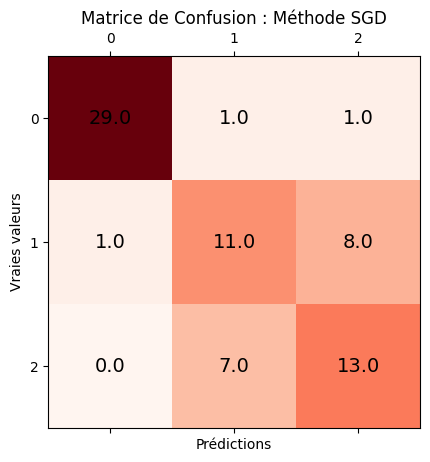

In [23]:
#Test SGDC
SGDClassifier = SGDClassifier()
model = SGDClassifier.fit(X_train, Y_train)

pred_SGD = cvp(model, X_train, Y_train, cv=3)

accuracy_SGD = cv(SGDClassifier, X_train, Y_train, cv=3, scoring="accuracy")
mat_SGD = confusion_matrix(Y_train, pred_SGD)


print("accuracy_SGD=", format(accuracy_SGD.mean(), '.2f'))


plt.matshow(mat_SGD, cmap=mpl.cm.Reds)
for (i,j), val in np.ndenumerate(mat_SGD):
  plt.text(j, i, f'{val:.1f}', ha='center', va='center', color='black', fontsize=14)
  plt.xlabel('Prédictions')
  plt.ylabel('Vraies valeurs')
  plt.title('Matrice de Confusion : Méthode SGD')

### TEST Random Forest Classifier

accuracy_RFC= 0.84


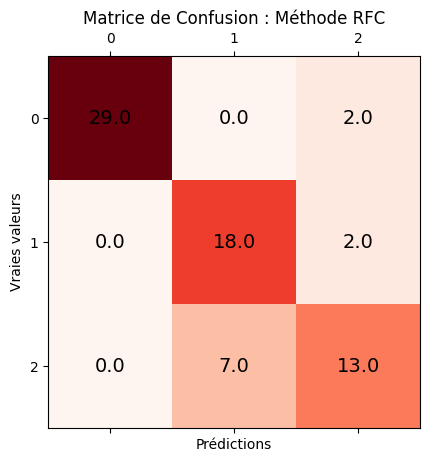

In [24]:
#Test Random Forest Classifier
RFC = RandomForestClassifier()
model = RFC.fit(X_train, Y_train)

pred_RFC = cvp(model, X_train, Y_train, cv=3)

accuracy_RFC = cv(RFC, X_train, Y_train, cv=3, scoring="accuracy")
mat_RFC = confusion_matrix(Y_train, pred_RFC)

print("accuracy_RFC=", format(accuracy_RFC.mean(), '.2f'))

plt.matshow(mat_RFC, cmap=mpl.cm.Reds)
for (i,j), val in np.ndenumerate(mat_RFC):
  plt.text(j, i, f'{val:.1f}', ha='center', va='center', color='black', fontsize=14)
  plt.xlabel('Prédictions')
  plt.ylabel('Vraies valeurs')
  plt.title('Matrice de Confusion : Méthode RFC')

### TEST Logistic Regression

accuracy_LR= 0.80


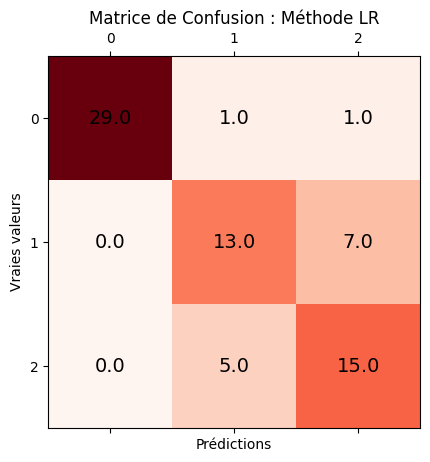

In [25]:
#Test Logistic Regression
LR = LogisticRegression()
model = LR.fit(X_train, Y_train)

pred_LR = cvp(model, X_train, Y_train, cv=3)

accuracy_LR = cv(LR, X_train, Y_train, cv=3, scoring="accuracy")
mat_LR = confusion_matrix(Y_train, pred_LR)

print("accuracy_LR=", format(accuracy_LR.mean(), '.2f'))

plt.matshow(mat_LR, cmap=mpl.cm.Reds)
for (i,j), val in np.ndenumerate(mat_LR):
  plt.text(j, i, f'{val:.1f}', ha='center', va='center', color='black', fontsize=14)
  plt.xlabel('Prédictions')
  plt.ylabel('Vraies valeurs')
  plt.title('Matrice de Confusion : Méthode LR')

## Grid Search

In [26]:
param_grid = [
    {'n_estimators': [50, 100, 500], 'max_features': ['sqrt'], 'max_depth':[5,10,20]},
]

grid = GridSearchCV(RFC, param_grid=param_grid, cv=3, scoring = "accuracy")
grid.fit(X_train, Y_train)
best_params = grid.best_params_
print(grid.best_params_)
pd.DataFrame(grid.cv_results_)

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.075926,0.003469,0.006909,0.001434,5,sqrt,50,"{'max_depth': 5, 'max_features': 'sqrt', 'n_es...",0.833333,0.875000,0.782609,0.830314,0.037779,9
1,0.151606,0.008519,0.008769,0.000230,5,sqrt,100,"{'max_depth': 5, 'max_features': 'sqrt', 'n_es...",0.875000,0.916667,0.782609,0.858092,0.056020,3
2,0.874098,0.184224,0.048087,0.011849,5,sqrt,500,"{'max_depth': 5, 'max_features': 'sqrt', 'n_es...",0.833333,0.916667,0.782609,0.844203,0.055266,6
3,0.119005,0.006940,0.008626,0.000655,10,sqrt,50,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",0.875000,0.916667,0.826087,0.872585,0.037018,1
4,0.244940,0.010603,0.013220,0.000838,10,sqrt,100,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",0.875000,0.916667,0.826087,0.872585,0.037018,1
5,0.920153,0.174794,0.046067,0.007476,10,sqrt,500,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",0.875000,0.916667,0.782609,0.858092,0.056020,3
6,0.073157,0.001077,0.005733,0.000289,20,sqrt,50,"{'max_depth': 20, 'max_features': 'sqrt', 'n_e...",0.875000,0.875000,0.782609,0.844203,0.043554,6
7,0.150943,0.010659,0.009176,0.000449,20,sqrt,100,"{'max_depth': 20, 'max_features': 'sqrt', 'n_e...",0.833333,0.916667,0.782609,0.844203,0.055266,6
8,0.719551,0.010471,0.035721,0.001191,20,sqrt,500,"{'max_depth': 20, 'max_features': 'sqrt', 'n_e...",0.875000,0.916667,0.782609,0.858092,0.056020,3


## Final Model

In [27]:
final_model = grid.best_estimator_

model = final_model.fit(X_train, Y_train)

pred_final_model = cvp(model, X_train, Y_train, cv=3)
accuracy_final_model = cv(final_model, X_train, Y_train, cv=3, scoring="accuracy")

print("accuracy_final_model=", format(accuracy_final_model.mean(), '.2f'))

accuracy_final_model= 0.84


### Extraction des Modeles

In [28]:
with open('scale_2.pkl', 'wb') as f:
  pickle.dump(scaler, f)

with open('model_2.pkl', 'wb') as f:
  pickle.dump(final_model, f)